# K-Nearest Neighbors (KNN) Classification – Wine Quality Dataset

In [49]:
"""
This notebook implements a complete, end-to-end KNN workflow
for predicting wine quality classes (low, medium, high) using
the Wine Quality dataset.

Coverage includes:
    • Exploratory Data Analysis (EDA)
    • Preprocessing & Feature Scaling
    • Stratified Train–Test Split
    • Baseline KNN Model
    • Hyperparameter Tuning (GridSearchCV)
    • Weighted vs Unweighted KNN Comparison
    • PCA Visualisation for Feature Understanding
    • Full Model Evaluation: Accuracy, F1, Confusion Matrix
    • Benchmark Comparison with Logistic Regression

Author: Mahesh Babu Poka
Date: 11 Dec 2025
Module: Machine Learning & Neural Networks
Instructor: Peter Scicluna
"""


'\nThis notebook implements a complete, end-to-end KNN workflow\nfor predicting wine quality classes (low, medium, high) using\nthe Wine Quality dataset.\n\nCoverage includes:\n    • Exploratory Data Analysis (EDA)\n    • Preprocessing & Feature Scaling\n    • Stratified Train–Test Split\n    • Baseline KNN Model\n    • Hyperparameter Tuning (GridSearchCV)\n    • Weighted vs Unweighted KNN Comparison\n    • PCA Visualisation for Feature Understanding\n    • Full Model Evaluation: Accuracy, F1, Confusion Matrix\n    • Benchmark Comparison with Logistic Regression\n\nAuthor: Mahesh Babu Poka\nDate: 11 Dec 2025\nModule: Machine Learning & Neural Networks\nInstructor: Peter Scicluna\n'

In [50]:
# ============================================
# 1. Import Libraries
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score
)

RANDOM_STATE = 42
sns.set(style="whitegrid", font_scale=1.1)

# Make plots look nicer in notebooks
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False


In [51]:
# ============================================
# 2. Load Dataset
# ============================================


# Adjust path if needed
data_path = r"C:\Mahesh Babu Poka\Machine Learning\WineQT.csv"
df = pd.read_csv(data_path)

print("Shape:", df.shape)
df.head()


Shape: (1143, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [52]:
# ============================================
# 2. Basic EDA & Data Quality Checks
# ============================================


print("\nData info:")
df.info()

print("\nMissing values per column:")
print(df.isna().sum())

print("\nDescriptive statistics:")
df.describe().T



Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB

Missing values per column:
fixed acidity           0
volatile 

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1143.0,8.311111,1.747595,4.60000,7.10000,7.90000,9.100000,15.90000
volatile acidity,1143.0,0.531339,0.179633,0.12000,0.39250,0.52000,0.640000,1.58000
citric acid,1143.0,0.268364,0.196686,0.00000,0.09000,0.25000,0.420000,1.00000
residual sugar,1143.0,2.532152,1.355917,0.90000,1.90000,2.20000,2.600000,15.50000
chlorides,1143.0,0.086933,0.047267,0.01200,0.07000,0.07900,0.090000,0.61100
free sulfur dioxide,1143.0,15.615486,10.250486,1.00000,7.00000,13.00000,21.000000,68.00000
total sulfur dioxide,1143.0,45.914698,32.782130,6.00000,21.00000,37.00000,61.000000,289.00000
density,1143.0,0.996730,0.001925,0.99007,0.99557,0.99668,0.997845,1.00369
pH,1143.0,3.311015,0.156664,2.74000,3.20500,3.31000,3.400000,4.01000
sulphates,1143.0,0.657708,0.170399,0.33000,0.55000,0.62000,0.730000,2.00000


In [53]:
# ============================================
# 3. Target Engineering & Cleaning
# --------------------------------------------
# Original 'quality' is an integer from 3 to 8.
# We'll create 3 classes:
#   3-4  -> 'low'
#   5-6  -> 'medium'
#   7-8  -> 'high'
# This is more realistic and good for class imbalance discussion.
# ============================================


bins = [0, 4, 6, 10]
labels = ["low", "medium", "high"]

df["quality_label"] = pd.cut(
    df["quality"],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True
)

print("Label distribution:")
print(df["quality_label"].value_counts())

# Drop the Id column (just an identifier)
if "Id" in df.columns:
    df = df.drop(columns=["Id"])

# Features (all numeric) and target (multi-class labels)
X = df.drop(columns=["quality_label"])
y = df["quality_label"]


Label distribution:
quality_label
medium    945
high      159
low        39
Name: count, dtype: int64


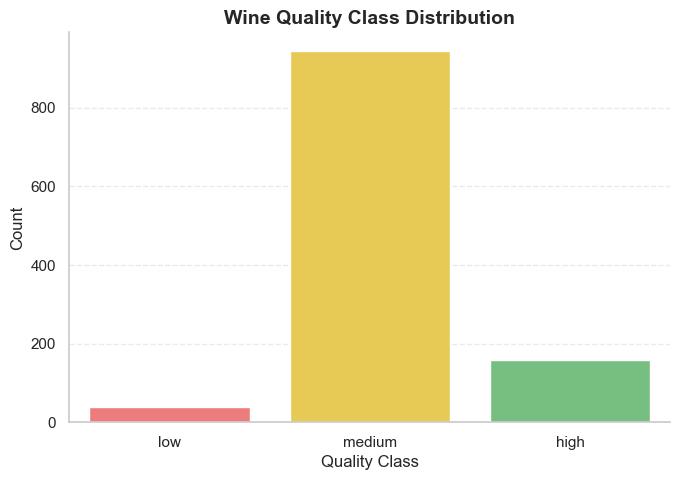

In [54]:
plt.figure(figsize=(7,5))

sns.countplot(
    x=y,
    hue=y,                                  # required for palette
    order=["low", "medium", "high"],
    palette=["#FF6B6B", "#FFD93D", "#6BCB77"],
    legend=False                            # remove duplicate legend
)

plt.title("Wine Quality Class Distribution", fontsize=14, fontweight="bold")
plt.xlabel("Quality Class", fontsize=12)
plt.ylabel("Count", fontsize=12)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


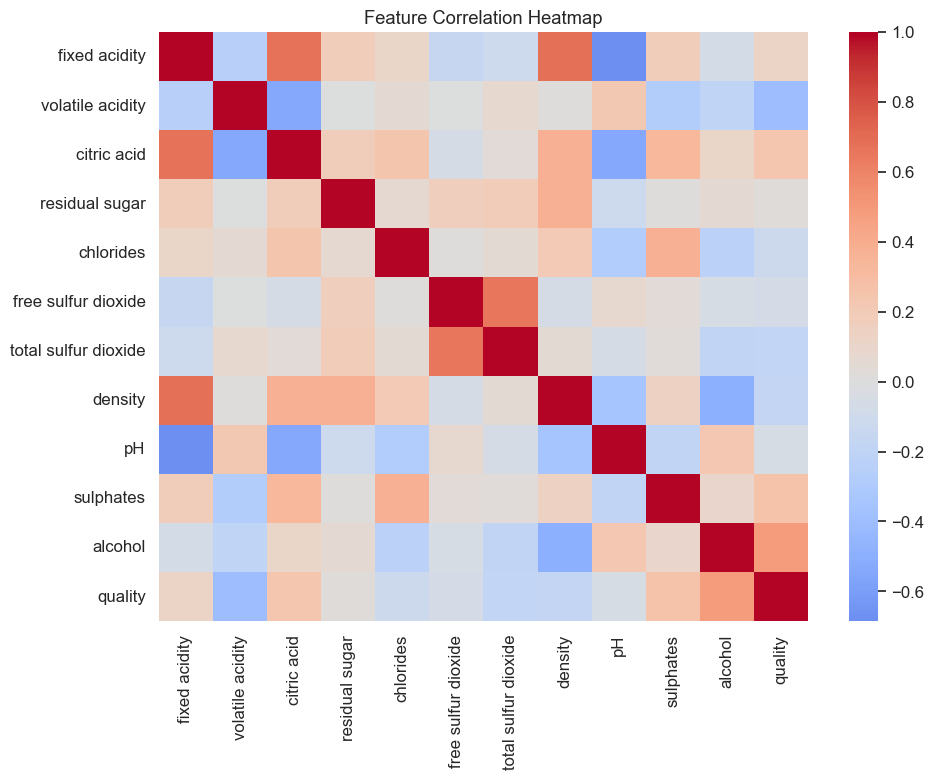

In [55]:
# ============================================
# 5. Correlation Heatmap (for Report)
# ============================================


plt.figure(figsize=(10, 8))
corr = df.drop(columns=["quality_label"]).corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


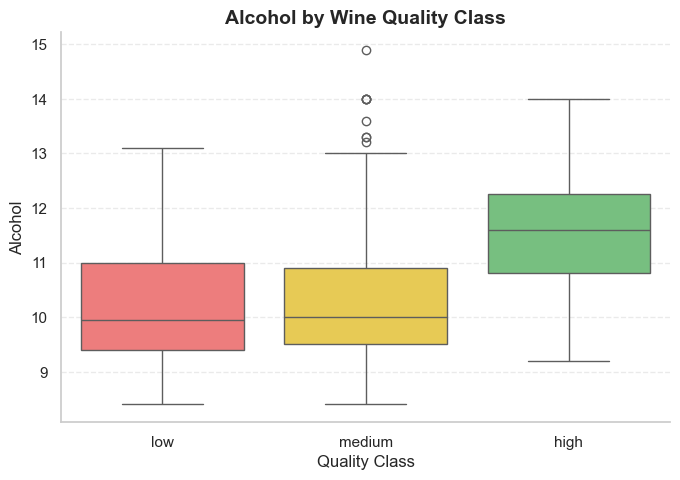

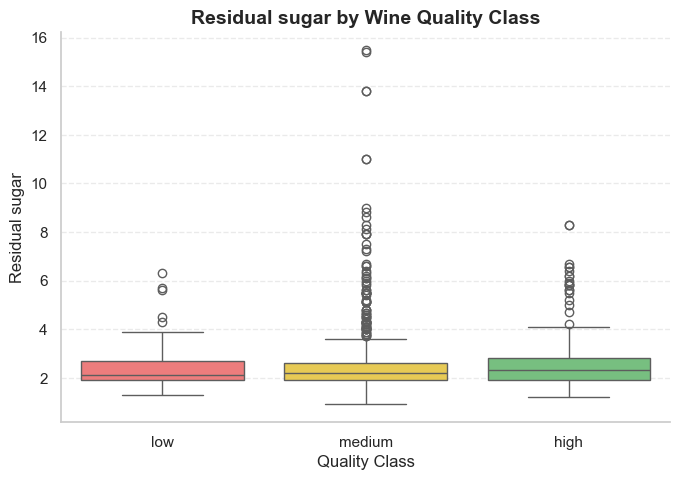

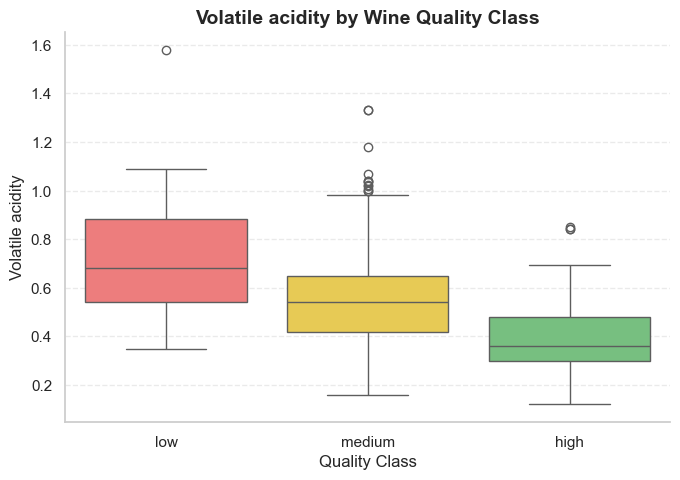

In [56]:
# ============================================
# 6. Feature Distributions by Class (Boxplot)
# ============================================

# Custom colour palette for classes
class_colors = ["#FF6B6B", "#FFD93D", "#6BCB77"]  # low, medium, high

key_features = ["alcohol", "residual sugar", "volatile acidity"]

for feat in key_features:
    plt.figure(figsize=(7,5))

    sns.boxplot(
        x="quality_label",
        y=feat,
        hue="quality_label",                 # required for palette in seaborn 0.14+
        data=df,
        order=["low", "medium", "high"],
        palette=class_colors,
        legend=False                          # hides duplicate legend
    )

    plt.title(f"{feat.capitalize()} by Wine Quality Class", fontsize=14, fontweight="bold")
    plt.xlabel("Quality Class", fontsize=12)
    plt.ylabel(feat.capitalize(), fontsize=12)

    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

    plt.grid(axis="y", linestyle="--", alpha=0.4)

    plt.tight_layout()
    plt.show()


In [57]:
# ============================================
# 7. Train-Test Split (Stratified)
# ============================================


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("\nTrain label distribution:")
print(y_train.value_counts(normalize=True))
print("\nTest label distribution:")
print(y_test.value_counts(normalize=True))


Train shape: (914, 12)
Test shape: (229, 12)

Train label distribution:
quality_label
medium    0.827133
high      0.138950
low       0.033917
Name: proportion, dtype: float64

Test label distribution:
quality_label
medium    0.825328
high      0.139738
low       0.034934
Name: proportion, dtype: float64


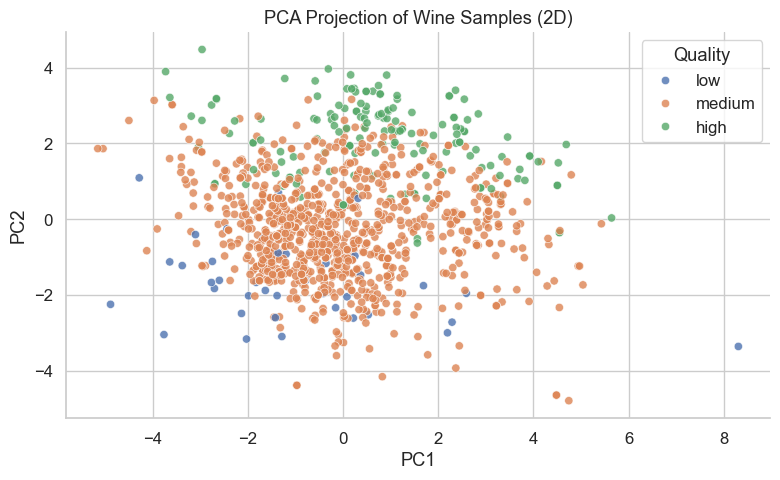

Explained variance ratio: [0.26480487 0.18621688]


In [58]:
# ============================================
# 8. PCA Visualization (2D) on Scaled Features
#    Great for report: shows separability of classes.
# ============================================


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["quality_label"] = y.values

plt.figure()
sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue="quality_label",
    hue_order=["low", "medium", "high"],
    alpha=0.8
)
plt.title("PCA Projection of Wine Samples (2D)")
plt.legend(title="Quality")
plt.tight_layout()
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)


In [59]:
# ============================================
# 9. Baseline KNN Model (k=5, uniform weights)
#    with Cross-Validation
# ============================================
knn_baseline_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(
        n_neighbors=5,
        weights="uniform",
        metric="minkowski",
        p=2
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
baseline_cv_scores = cross_val_score(
    knn_baseline_pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring="f1_macro"
)

print("Baseline KNN (k=5, uniform) CV F1-macro scores:", baseline_cv_scores)
print("Baseline KNN mean F1-macro: {:.4f} ± {:.4f}".format(
    baseline_cv_scores.mean(), baseline_cv_scores.std()
))


Baseline KNN (k=5, uniform) CV F1-macro scores: [0.6010582  0.69943886 0.57721776 0.57291967 0.67017275]
Baseline KNN mean F1-macro: 0.6242 ± 0.0513


In [60]:
# ============================================
# 10. Hyperparameter Tuning for KNN (GridSearchCV)
#     - n_neighbors
#     - weights: uniform vs distance
#     - p: 1 (Manhattan) vs 2 (Euclidean)
# ============================================
knn_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

param_grid = {
    "knn__n_neighbors": list(range(1, 26)),     # k = 1 to 25
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2]                            # 1=Manhattan, 2=Euclidean
}

grid_search = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV F1-macro: {:.4f}".format(grid_search.best_score_))


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'knn__n_neighbors': 1, 'knn__p': 2, 'knn__weights': 'uniform'}
Best CV F1-macro: 0.7801


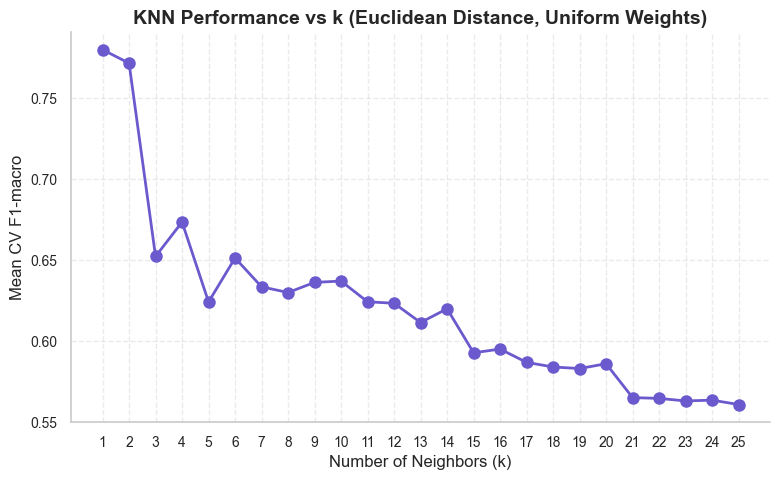

In [61]:
# ============================================
# 11. Plot Accuracy / F1 vs k (for Report)
#     Focus on Euclidean distance (p=2), uniform weights
# ============================================

results = pd.DataFrame(grid_search.cv_results_)

mask = (
    (results["param_knn__weights"] == "uniform") &
    (results["param_knn__p"] == 2)
)

subset = results[mask].copy()
subset["k"] = subset["param_knn__n_neighbors"].astype(int)

plt.figure(figsize=(8,5))

plt.plot(
    subset["k"],
    subset["mean_test_score"],
    marker="o",
    markersize=8,
    linewidth=2,
    color="#6A5ACD"   # soft purple for a clean ML look
)

plt.title("KNN Performance vs k (Euclidean Distance, Uniform Weights)",
          fontsize=14, fontweight="bold")
plt.xlabel("Number of Neighbors (k)", fontsize=12)
plt.ylabel("Mean CV F1-macro", fontsize=12)

plt.xticks(subset["k"], fontsize=10)
plt.yticks(fontsize=10)

plt.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


Test Accuracy (KNN): 0.9738
Test F1-macro (KNN): 0.8891

Classification Report (KNN):
              precision    recall  f1-score   support

        high     0.9688    0.9688    0.9688        32
         low     0.8333    0.6250    0.7143         8
      medium     0.9791    0.9894    0.9842       189

    accuracy                         0.9738       229
   macro avg     0.9270    0.8611    0.8891       229
weighted avg     0.9725    0.9738    0.9726       229



<Figure size 800x500 with 0 Axes>

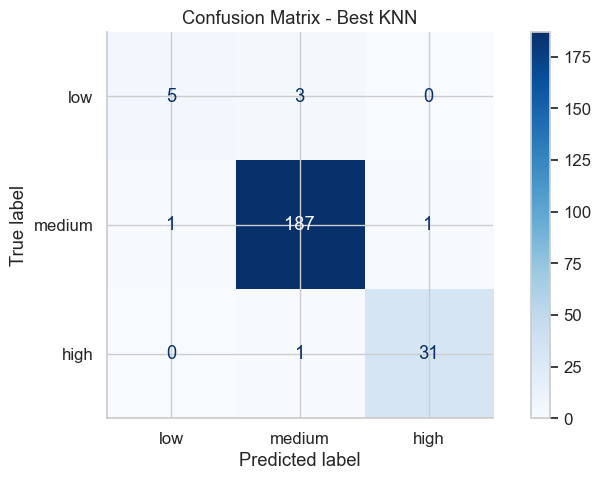

In [62]:
# ============================================
# 12. Evaluate Best KNN Model on Test Set
# ============================================


best_knn = grid_search.best_estimator_

y_pred_knn = best_knn.predict(X_test)

print("Test Accuracy (KNN): {:.4f}".format(accuracy_score(y_test, y_pred_knn)))
print("Test F1-macro (KNN): {:.4f}".format(f1_score(y_test, y_pred_knn, average="macro")))
print("\nClassification Report (KNN):")
print(classification_report(y_test, y_pred_knn, digits=4))

cm_knn = confusion_matrix(y_test, y_pred_knn, labels=["low", "medium", "high"])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_knn,
    display_labels=["low", "medium", "high"]
)
plt.figure()
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Best KNN")
plt.tight_layout()
plt.show()


Logistic Regression CV F1-macro scores: [0.93115468 1.         0.96859686 1.         1.        ]
Logistic Regression mean F1-macro: 0.9800 ± 0.0273

Test Accuracy (LogReg): 0.9956
Test F1-macro (LogReg): 0.9769

Classification Report (LogReg):
              precision    recall  f1-score   support

        high     1.0000    1.0000    1.0000        32
         low     1.0000    0.8750    0.9333         8
      medium     0.9947    1.0000    0.9974       189

    accuracy                         0.9956       229
   macro avg     0.9982    0.9583    0.9769       229
weighted avg     0.9957    0.9956    0.9955       229



<Figure size 700x500 with 0 Axes>

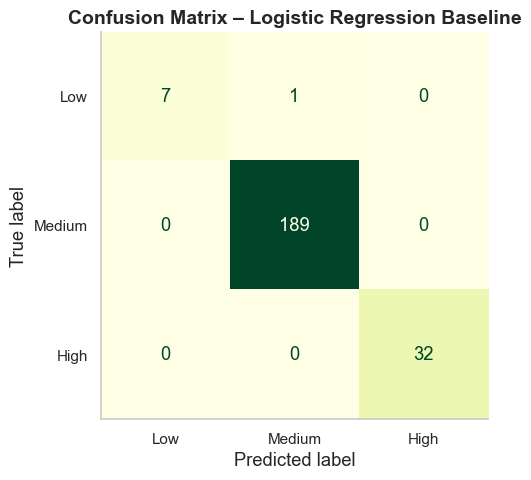

In [63]:
# ============================================
# 13. Baseline Model: Logistic Regression
#     For comparison with KNN (very important in report)
# ============================================
logreg_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        solver="lbfgs",
        max_iter=1000,
        random_state=RANDOM_STATE
        # multi_class removed to avoid FutureWarning (defaults to multinomial)
    ))
])

logreg_cv_scores = cross_val_score(
    logreg_pipeline,
    X_train,
    y_train,
    cv=cv,
    scoring="f1_macro"
)

print("Logistic Regression CV F1-macro scores:", logreg_cv_scores)
print("Logistic Regression mean F1-macro: {:.4f} ± {:.4f}".format(
    logreg_cv_scores.mean(),
    logreg_cv_scores.std()
))

# Fit on full training set
logreg_pipeline.fit(X_train, y_train)
y_pred_logreg = logreg_pipeline.predict(X_test)

print("\nTest Accuracy (LogReg): {:.4f}".format(accuracy_score(y_test, y_pred_logreg)))
print("Test F1-macro (LogReg): {:.4f}".format(f1_score(y_test, y_pred_logreg, average="macro")))
print("\nClassification Report (LogReg):")
print(classification_report(y_test, y_pred_logreg, digits=4))

# Confusion matrix
cm_logreg = confusion_matrix(y_test, y_pred_logreg, labels=["low", "medium", "high"])

plt.figure(figsize=(7,5))

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_logreg,
    display_labels=["Low", "Medium", "High"]
)

disp.plot(
    cmap="YlGn",          # elegant yellow-green
    values_format="d",
    colorbar=False
)

plt.title("Confusion Matrix – Logistic Regression Baseline", fontsize=14, fontweight="bold")
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(False)

plt.tight_layout()
plt.show()


In [64]:
# ============================================
# 14. Summary Cell (for Notebook / Supervisor)
#     You can use this text in your report's discussion section.
# ============================================
print("Best KNN parameters:", grid_search.best_params_)
print("KNN vs Logistic Regression (Test F1-macro):")
print("  KNN:       {:.4f}".format(f1_score(y_test, y_pred_knn, average="macro")))
print("  LogReg:    {:.4f}".format(f1_score(y_test, y_pred_logreg, average="macro")))


Best KNN parameters: {'knn__n_neighbors': 1, 'knn__p': 2, 'knn__weights': 'uniform'}
KNN vs Logistic Regression (Test F1-macro):
  KNN:       0.8891
  LogReg:    0.9769
